## Scattered data interpolation

This notebook describes and compares several methods of scattered data interpolation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import Sampling
from gplusb import gplusb
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = [8., 8.]

### The problem: inferring an image from a noisy, irregular sampling

In [2]:
sampling = Sampling(nsamples=1000, sigmarange=[1., 4.])

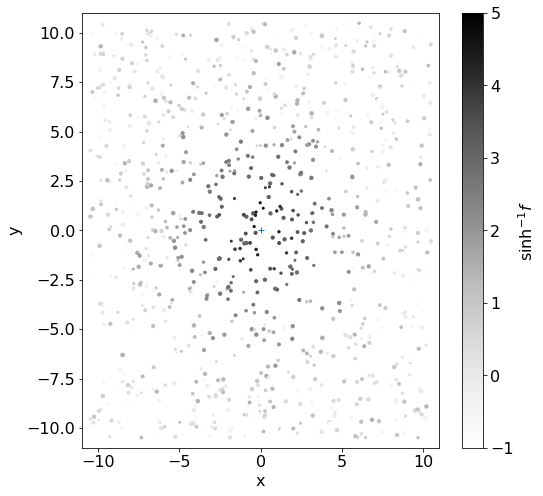

In [3]:
sampling.set_flux(total_flux=1000., noise=1.)
sampling.imshow()
plt.savefig('../tex/figures/scattered-data.png', dpi=300)

### Gaussian process method

A classic method in this situation is Shepard's method, which uses a radial function to assign weights to points on the desired grid. We define:

 * The vector of samples $\vec{f}$, of length $N$,
 * An image $\vec{S}$, the set of values resulting from Shepard's procedure
 
The image is determined by:

$$\vec{S} = \mathbf{W}\cdot \vec{f}$$
 
where the weights are:

$$W_{ij} = 
  \frac{1}{W_{0,i}}\exp\left(-\frac{r_{ij}^2}{2\sigma_0^2}\right)$$
  
for $r_{ij} < r_{\rm lim}$, and zero otherwise. 
$W_{0, i}$ is
defined as the sum of the $N$ weights for each output grid point $i$,
to guarantee the conservation of flux:
$$W_{0, i} =\sum_{j}\exp\left(-\frac{r_{ij}^2}{2 \sigma_0^2}\right)$$



We will first set up the desired output grid. We choose a pixel sampling of about 1 unit of distance, since the smallest FWHM of the kernel is a little bigger than 2 units of distance.

We will calculate weights using $\sigma_0 = 0.75$.

In [4]:
def shepard_weights(sampling, sigma0=0.75):
    W_S = np.zeros((sampling.nx * sampling.ny, sampling.nsamples))
    for j in np.arange(sampling.nsamples):
        rij2 = ((sampling.xgrid - sampling.x[j])**2 +
                (sampling.ygrid - sampling.y[j])**2)
        W_S[:, j] = np.exp(- 0.5 * rij2 / sigma0**2)
    for i in np.arange(sampling.nx * sampling.ny):
        W_S[i, :] = W_S[i, :] / W_S[i, :].sum()
    return(W_S)

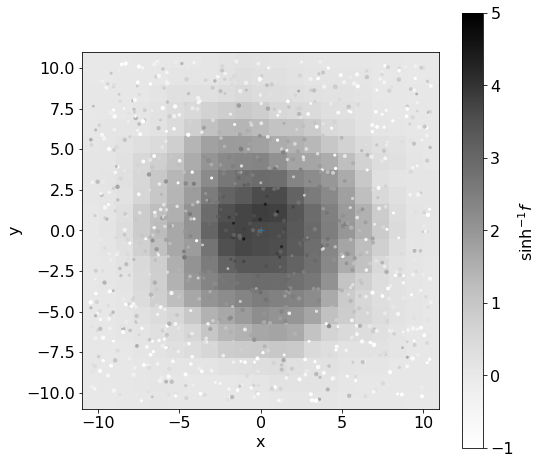

In [12]:
W_S = shepard_weights(sampling, sigma0=0.75)
S_S = W_S.dot(sampling.flux_nonoise).reshape(sampling.nx, sampling.ny)
sampling.imshow(S_S)
plt.savefig('../tex/figures/scattered-shepard.png', dpi=300)

In [13]:
sigma, flux, background, model = gplusb(sampling, S_S)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))

Optimization terminated successfully.
         Current function value: 177.731859
         Iterations: 16
         Function evaluations: 32
sigma = 2.4505184824331545
flux = 812.7327897972502
background = 0.22754319483293228


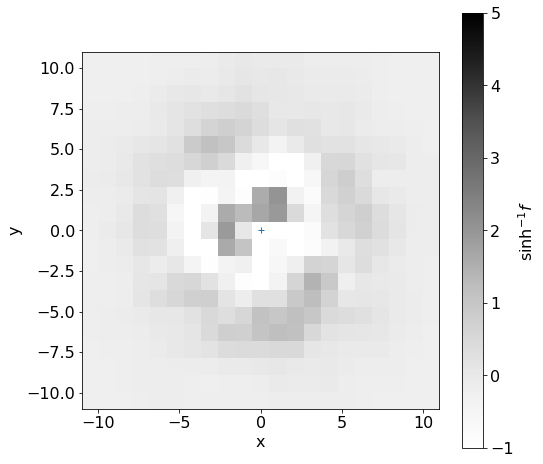

In [14]:
sampling.imshow(S_S - model, nopoints=True)

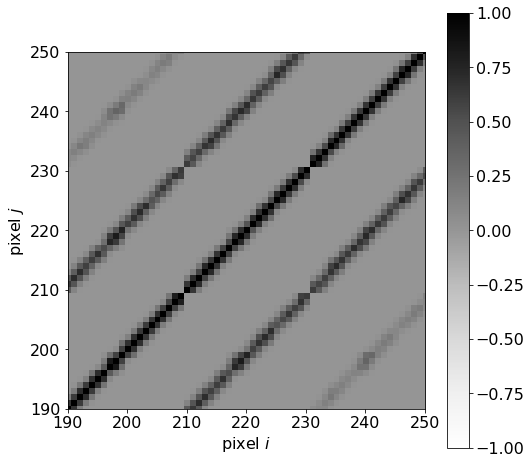

In [15]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
C_S = W_S.dot(W_S.T)
CC_S = 0. * C_S
for i in np.arange(sampling.nx * sampling.ny):
    for j in np.arange(sampling.nx * sampling.ny):
        CC_S[i, j] = C_S[i, j] / np.sqrt(C_S[i, i] * C_S[j, j])
plt.imshow(CC_S, **myargs, vmin=-1., vmax=1)
nmid = (sampling.nx * sampling.ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-shepard-covar.png', dpi=300)

## Testing broadening due to the weights

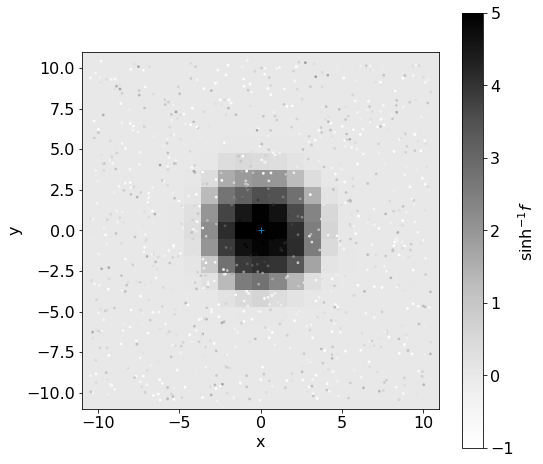

In [17]:
sampling = Sampling(nsamples=1000, sigmarange=[1., 1.])
sampling.set_flux(total_flux=1000., noise=1.)
W_S = shepard_weights(sampling, sigma0=0.75)
S_S = W_S.dot(sampling.flux_nonoise).reshape(sampling.nx, sampling.ny)
sampling.imshow(S_S)

In [18]:
sigma, flux, background, model = gplusb(sampling, S_S)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))

Optimization terminated successfully.
         Current function value: 553.883652
         Iterations: 15
         Function evaluations: 30
sigma = 1.2734060208857299
flux = 981.6749273068314
background = 0.00762030936726088


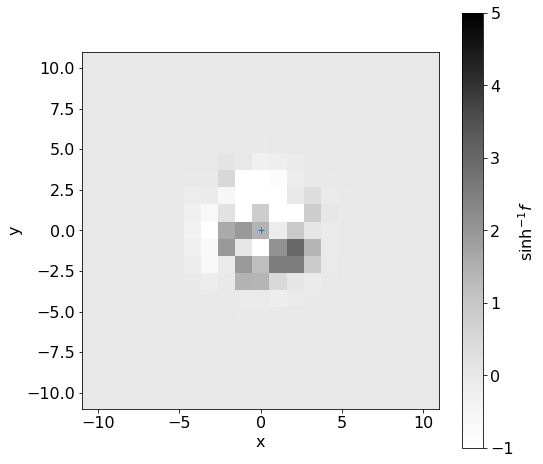

In [19]:
sampling.imshow(S_S - model, nopoints=True)

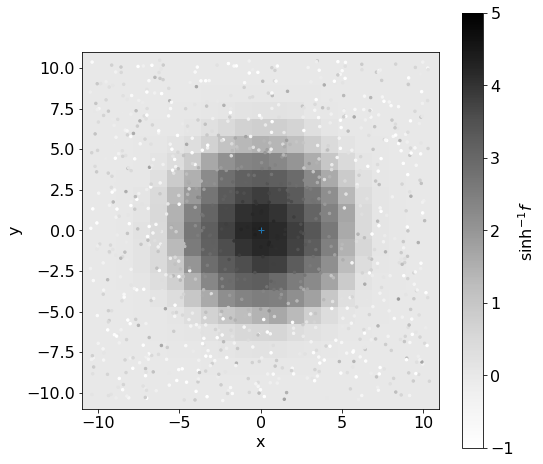

In [21]:
sampling = Sampling(nsamples=1000, sigmarange=[2., 2.])
sampling.set_flux(total_flux=1000., noise=1.)
W_S = shepard_weights(sampling, sigma0=0.75)
S_S = W_S.dot(sampling.flux_nonoise).reshape(sampling.nx, sampling.ny)
sampling.imshow(S_S)

In [22]:
sigma, flux, background, model = gplusb(sampling, S_S)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))

Optimization terminated successfully.
         Current function value: 71.331703
         Iterations: 15
         Function evaluations: 30
sigma = 2.0992028351988914
flux = 978.7737289497378
background = 0.031708949364903205


In [23]:
print(np.sqrt(0.75**2 + 2.**2))

2.1360009363293826


In [9]:
print(x)

NameError: name 'x' is not defined

In [10]:
import sklearn
import sklearn.gaussian_process

In [11]:
help(sklearn.gaussian_process)

Help on package sklearn.gaussian_process in sklearn:

NAME
    sklearn.gaussian_process

DESCRIPTION
    The :mod:`sklearn.gaussian_process` module implements Gaussian Process
    based regression and classification.

PACKAGE CONTENTS
    correlation_models
    gaussian_process
    gpc
    gpr
    kernels
    regression_models
    tests (package)

CLASSES
    sklearn.base.BaseEstimator(builtins.object)
        sklearn.gaussian_process.gaussian_process.GaussianProcess(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin)
        sklearn.gaussian_process.gpc.GaussianProcessClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin)
        sklearn.gaussian_process.gpr.GaussianProcessRegressor(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin)
    sklearn.base.ClassifierMixin(builtins.object)
        sklearn.gaussian_process.gpc.GaussianProcessClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin)
    sklearn.base.RegressorMixin(builtins.object)
        skl